# Lesson 7 - Filtros Colaborativos

**Dataset:** [Book-Crossing: User review ratings](https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset)

## Objetivo

O objetivo deste presente trabalho é criar um modelo de recomendação de animes usando o dataset acima, aplicando filtros colaborativos.

## Autor

- Luís Guilherme Gaboardi Lins / 180022962

## Instalação das dependências e dos dados

In [1]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None


<AxesSubplot:>

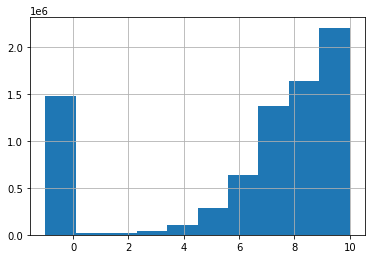

In [33]:
path = Path('/kaggle/input/anime-recommendations-database')
ratings = pd.read_csv(path/'rating.csv')
print(ratings.info())
ratings['rating'].hist()

In [5]:
animes = pd.read_csv(path/'anime.csv')
animes.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.16,151266


In [11]:
ratings = ratings.merge(animes)
ratings.drop(['genre', 'type', 'episodes', 'members'], axis=1, inplace=True)
ratings.head()

,user_id,anime_id,rating,name
0,17,3287,2,Tenkuu Danzai Skelter+Heaven
1,3479,3287,2,Tenkuu Danzai Skelter+Heaven
2,9584,3287,2,Tenkuu Danzai Skelter+Heaven
3,9867,3287,2,Tenkuu Danzai Skelter+Heaven
4,10557,3287,2,Tenkuu Danzai Skelter+Heaven


In [12]:
dls = CollabDataLoaders.from_df(ratings, item_name='name', bs=64)
dls.show_batch()

,user_id,name,rating
0,26501,Detective Conan Movie 02: The Fourteenth Target,8
1,7643,Rio: Rainbow Gate!,6
2,8202,Maria-sama ga Miteru 3rd,8
3,62212,Schwarzesmarken,7
4,73378,Little Witch Academia,8
5,57750,Cossette no Shouzou,7
6,60171,Sword Art Online: Extra Edition,7
7,42154,Dragon Ball Z: Zenbu Misemasu Toshi Wasure Dragon Ball Z!,7
8,26186,Schwarzesmarken,7
9,40812,Sex Pistols,7


In [14]:
n_users = len(dls.classes['user_id'])
n_animes = len(dls.classes['name'])
n_factors = 50

As variáveis `n_users` e `n_animes` recebem o número de usuários e de animes no conjunto de dados. Isso pois foi utilizado a função `len()` para calcular o comprimento das colunas, selecionadas através de `dls.classes[coluna]`. Coloquei como *50* fatores latentes.

Agora como parte da lição 7, o Jeremy passa pela criação do produto escalar por etapas. No caso, em referência à lição 7 fiz uma função de produto escalar:

In [23]:
class DotProductBias(Module):
    def __init__(self, n_users, n_animes, n_factors, y_range=(0, 10.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.anime_factors = Embedding(n_animes, n_factors)
        self.anime_bias = Embedding(n_animes, 1)
        self.y_range = y_range
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        animes = self.anime_factors(x[:,1])
        res = (users * animes).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.anime_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

No código acima tenho a importação da classe `Module` do módulo `torch.nn` do PyTorch que é usada para definir modelos de aprendizagem de máquina, dela é fronecido funcionalidades e métodos comuns para criar e gerenciar modelos. Assim, criei a classe `DotProductBias`, com `__init__` sendo construtor da classe que inicia os atributos da classe e define as camadas e parâmetros necessários para o modelo, `n_users` é o número de usuários e `n_animes` de animes do conjunto dados, `n_factors` ~e o número de fatores latentes a serem usados, no caso definir como 5, `y_range` é um intervalo de valores esperados para as previsôes do modelo. Para as partes usando o `Embedding` estou fazendo uma incorporação para representar os usuários e os animes, no caso de `*_factors` estou querendo usar a camada de incorporação para representar os usuários e animes, no caso de `*_bias`estou querendo representar o viés dos usuários e animes. Seguindo para `foward()` este metodo define a passagem direta do modelo, sendo *x* um tensor de entrada que contém os índices dos usuários e filme, `users` e `animes` usam as camadas de incorporação para obter os fatores latentes correspodentes a cada um dele presente em `x[:,0]` e `x[:,1]`. Assim faço a some do produto escalar dos fatores latentes de `users` e `animes` em `(users * animes).sum(dim=1, keepdim=True)` ao longo da dimensão 1 `dim=1` e matenho as dimensões da matriz em `keepdim=True`. O resultado dessa soma é uma matriz de previsões parciais para cada par usuário-anime. Assim sigo para adicionar os viéses dos usuário e dos filme às previsões parcias, auxiliando as previsões de acordo com os padrões específicos de cada usuário e anime em `res += self.user_bias(x[:,0]) + self.book_bias(x[:,1])`. Com isso feito, dou um retorno da função `sigmoid_range` em que é aplicado uma função de ativação sigmoidal às previsões resultantes e aplica um redimensionamento linear para garantir que as previsões estejam dentro do intervalo definidao por `y_range`.

Agora treino o modelo aplicando o conceito de Decaimento por peso, que consiste em adicionar para a função de loss a soma de todos os pasos ao quadrado, para encorajar o pesos a serem o mais pequenos possíveis:

In [24]:
model = DotProductBias(n_users, n_animes, n_factors)
learn_dot = Learner(dls, model, loss_func=MSELossFlat())

In [29]:
learn_dot.fit_one_cycle(10, 0.05, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.258835,0.116134,00:00
1,0.160251,0.104171,00:00
2,0.348884,0.354920,00:00
3,0.940056,0.477796,00:00
4,0.951645,0.282928,00:00
5,0.558976,0.124992,00:00
6,0.293962,0.062142,00:00
7,0.136807,0.028877,00:00
8,0.044535,0.022025,00:00
9,0.015686,0.021180,00:00


No código acima, criei uma instância do modelo `DotProductBias` com base no número de usuários, número de animes e 50 fatores latentes. Em seguida, ele cria um objeto `Learner` com base nos dados de treinamento, no modelo e a função de perda `MSELossFlat`. Depois disso apliquei o método `fit_one_cycle` para treinar o modelo por 5 épocas, com uma taxa de aprendizagem inicial de 11e-3 e uma peso de decaimento (weight decay) de 0.1. O peso de decaimento consiste em adicionar a função de loss a som de todos os pesos quadráticos, para que quando computo os gradientes, vai adicionar uma constribuição para eles em que vai encorajar os pesoas a serem os mais pequenos possíveis.

Agora para finalizar a parte do desenvolvimento do artigo e da produção do modelo, criei um modelo deep learning para a filtragem colaborativa. Para isso, comecei colocando na variável `embs` o retorno da recomendação da função do *fastai* `get_emb_sz` dá de tamanho de incorporação de matrizes para o dado que estou usando,

In [34]:
embs = get_emb_sz(dls)
embs

[(4805, 184), (84, 19)]

Agora implemento essa classe:

In [35]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,10.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

A classe `CollabNN` implementa um modelo de filtragem colaborativa com redes neurais. Esse modelo é usado para fazer previsões ou recomendações com base em dados de usuários e itens, analisando como ele funciona tenho:

No método `__init__`, são definidos os atributos da classe. `user_sz` e `item_sz` são tuplas que contêm o número de usuários e itens no conjunto de dados, respectivamente, bem como a dimensão dos fatores latentes para usuários e itens. O intervalo `y_range` especifica os valores esperados das previsões do modelo, e `n_act` determina o número de neurônios na camada oculta da rede neural.

Em seguida, são criadas as camadas de incorporação (embedding) para representar os usuários e itens. A camada de incorporação para os usuários tem dimensão de acordo com `user_sz`, e a camada de incorporação para os itens tem dimensão de acordo com `item_sz`.

A rede neural é definida usando a classe `nn.Sequential`, que permite empilhar camadas sequencialmente. Ela consiste em uma camada linear de entrada, uma função de ativação `ReLU` e uma camada linear de saída. A camada linear de entrada recebe as representações concatenadas dos usuários e itens como entrada, enquanto a camada linear de saída produz uma única saída, que é a previsão final do modelo.

No método `forward`, o tensor de entrada *x* contém os índices dos usuários e itens. A partir desses índices, são obtidas as representações de incorporação dos usuários e itens correspondentes. Essas representações são então concatenadas ao longo da dimensão 1 para formar um único tensor de entrada para a rede neural.

Esse tensor é passado pelas camadas da rede neural definidas anteriormente, e a saída resultante é aplicada a uma função de ativação sigmoidal. Essa função sigmoidal garante que as previsões estejam dentro do intervalo especificado por `y_range`. Por fim, as previsões redimensionadas são retornadas como saída do método forward.

E assim, utilizo para criar o modelo e fazer o treino dele:

In [36]:
model = CollabNN(*embs)
learn_deep = Learner(dls, model, loss_func=MSELossFlat())
learn_deep.fit_one_cycle(10, 0.005, wd=0.01)

epoch,train_loss,valid_loss,time
0,1.955146,0.278059,00:01
1,0.311221,0.010055,00:00
2,0.051357,0.009039,00:00
3,0.010142,0.009643,00:00
4,0.003202,0.008313,00:00
5,0.001371,0.007212,00:00
6,0.000592,0.007310,00:00
7,0.000226,0.007039,00:00
8,0.000066,0.006965,00:00
9,0.000023,0.006970,00:00


Essas linhas de código têm o objetivo de criar e treinar um modelo de filtragem colaborativa. Entendendo o que cada parte faz:

Na linha `model = CollabNN(*embs)`, um objeto chamado model é criado. Ele representa o modelo de filtragem colaborativa e utiliza as representações de incorporação dos usuários e itens, que estão armazenadas na variável embs. O desempacotamento `(*embs)` permite passar as representações corretas para o construtor da classe *CollabNN*, inicializando o modelo adequadamente.

Na linha `learn = Learner(dls, model, loss_func=MSELossFlat())`, um objeto chamado learn é criado. Ele representa o objeto de aprendizado (learner) responsável por treinar o modelo. O objeto dls contém o conjunto de dados de treinamento e validação. O modelo criado anteriormente (model) é passado como argumento, juntamente com a função de perda *MSELossFlat()*, que mede o erro quadrático médio entre as previsões do modelo e os rótulos reais.

Na linha `learn.fit_one_cycle(15, 10e-2, wd=0.01)`, o método `fit_one_cycle()` é chamado para treinar o modelo. Ele recebe três argumentos: o número de épocas de treinamento (15), a taxa de aprendizado (10e-2) e a força da regularização (0.01). Durante o treinamento, o modelo será ajustado aos dados em várias iterações (épocas) para fazer previsões mais precisas.

Feito isso, passei para a exportação do modelo para utilizá-lo no aplicativo do Hugging Face:

## Inferência

Após montar os modelos, fiz alguns testes para ver como reagiam ao pedido de recomendação de um usuário, mas também é interessante ver que parâmetros tem descoberto. O caminho mais fácill é pelo viés. Aqui os livros estão com os menores valores no vetor de viéses:

In [38]:
anime_bias_dot = learn_dot.model.anime_bias.weight.squeeze()
idxs = anime_bias_dot.argsort()[:5]
[dls.classes['name'][i] for i in idxs]

['Tenkuu Danzai Skelter+Heaven',
 'Tekusuke Monogatari',
 'Gensei Shugoshin P-hyoro Ikka',
 'Heisei Jogakuen Kagai Lesson',
 'Papillon Rose']

No código acima tenho que a variável `anime_bias_dot` recebe o vetor de viés dos animes que contem os menores pesos relacioandos as animes aprendido no modelo. Assim classifiquei os índices do vetor `anime_bias_dot` em ordem crescente e usei a função `argsort()` para retornar os índices que ordenariam o vetor. Em seguida, selecionei os primerios cinco índices usando ` [:5]` e atribuí à variável `idxs`. Por fim imprimo uma lista dos cinco títulos de animes com os menores valores de viés usando `[dls.classes['title'][i] for i in idxs]`. 

Assim, também vou apresentar quais são os animes de maior viés:

In [40]:
idxs = anime_bias_dot.argsort(descending=True)[:5]
[dls.classes['name'][i] for i in idxs]

['Little Witch Academia',
 'Gekkan Shoujo Nozaki-kun Specials',
 'Detective Conan Movie 02: The Fourteenth Target',
 'City Hunter',
 'Kamisama Hajimemashita OVA']

In [61]:
animes.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,13,9.11,81109


In [62]:
animes_factors_dot = learn_dot.model.anime_factors.weight
idx = dls.classes['name'].o2i['Sword Art Online']
distances = nn.CosineSimilarity(dim=1)(animes_factors_dot, animes_factors_dot[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['name'][idx]

'Monster Strike: Mermaid Rhapsody'

Em referencia ao grafico plotado, o output da linha anterior deveria ter retornando um anime ao redor do anime que escolhi para o teste, porém não ocorreu, isso pode se dar a vários fatores, o loss de treino e validação ficaram muito discrepantes e etc.

Assim, fiz o teste de criar um novo usuário e recomendar anime para ele.

Assim, fiz o export do *modelo* e o apliquei no aplicativo que se encontra no HuggingFace no link

https://huggingface.co/spaces/luisgaboardi/anime-recommendation

In [63]:
learn_deep.export('model.pkl')